In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers                       
import matplotlib.pyplot as plt   
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np 
import cv2   
import os

In [70]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = "dataset/"
CATEGORIES = ["with_mask", "without_mask"]

In [9]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = tf.keras.preprocessing.image.load_img(img_path, target_size = (224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.keras.applications.mobilenet.preprocess_input(image)
        data.append(image)
        labels.append(category)

C:\Users\sahil\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [14]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [15]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

In [17]:
# construct the training image generator for data augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [50]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))

# Loading the MobileNetV2 model with the input tensor
baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_tensor)



C:\Users\sahil\AppData\Local\Temp\ipykernel_4324\2008131976.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_tensor)


In [25]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(2, activation="softmax")(headModel)

In [27]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [28]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [30]:
# compile our model
print("[INFO] compiling model...")
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer= "adam",metrics=["accuracy"])

[INFO] compiling model...


In [78]:
# train the head of the network
print("[INFO] Training Head Neural Network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)
# H = model.fit(trainX, trainY, epochs = 10, validation_split = 0.3)

[INFO] Training Head Neural Network...
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 949ms/step - accuracy: 0.9880 - loss: 0.0339 - val_accuracy: 0.9857 - val_loss: 0.0484
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 1.0000 - loss: 0.0143 
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 94s 991ms/step - accuracy: 0.9882 - loss: 0.0232 - val_accuracy: 0.9948 - val_loss: 0.0208
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 1.0000 - loss: 0.0092 
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9936 - loss: 0.0171 - val_accuracy: 0.9935 - val_loss: 0.0210
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0148   
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9949 - loss: 0.0146 - val_accuracy: 0.9909 - val_loss: 0.0321
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.9688 - loss: 0.0570 
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 93s 983ms/step - accuracy: 0.9933 - loss: 0.0180 - val_accuracy

In [79]:
# make predictions on the testing set
print("[INFO] Evaluating Network...")
predIdxs = model.predict(testX, batch_size=BS)
# Now you can evaluate the model
metrics = model.evaluate(testX, testY)
print(metrics)

[INFO] Evaluating Network...
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 478ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 472ms/step - accuracy: 0.9914 - loss: 0.0286
[0.029002312570810318, 0.9921773076057434]


In [80]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [81]:
model.save('My_Model.h5')

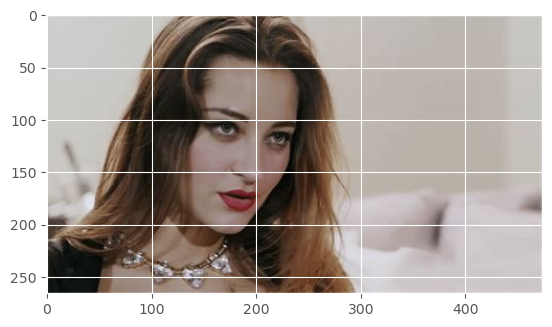

In [66]:
frame = cv2.imread("test.jpg")
if frame is None or frame.size == 0:
    print("Error: Frame is empty.")
else:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [72]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [74]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [75]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)
for x, y, w, h in faces:
    roi_gray = gray[y : y + h, x : x + w]
    roi_color = frame[y : y + h, x : x + w]
    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not Detected !!")
    else:
        for(ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey : ey + eh, ex : ex + ew]

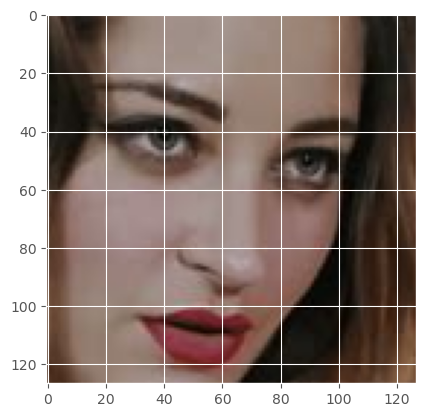

In [76]:
if frame is None or frame.size == 0:
    print("Error: Frame is empty.")
else:
    plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [77]:
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis = 0)     #need fourth dimensions
final_image = final_image / 255.0
Predictions = model.predict(final_image)
Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[9.9995947e-01, 4.0577012e-05]], dtype=float32)

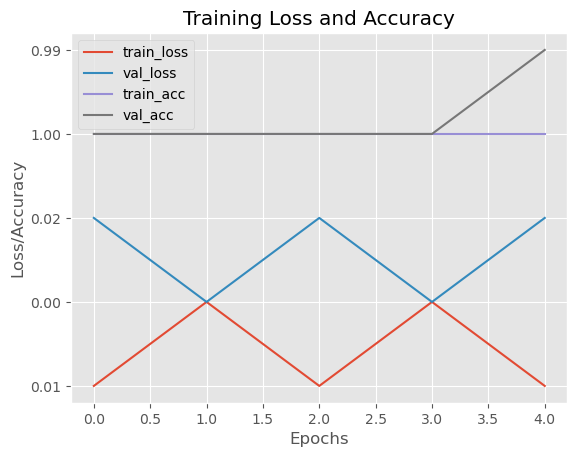

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming H is your training history object
N = len(H.history["loss"])  # Use the length of the training loss history

# Extract values from history
loss_Val = H.history["loss"]
valloss_Val = H.history.get("val_loss", [])
acc_Val = H.history["accuracy"]
valacc_Val = H.history.get("val_accuracy", [])

# Format the values for plotting
formatted_loss = [format(loss, ".2f") for loss in loss_Val]
formatted_valloss = [format(val_loss, ".2f") for val_loss in valloss_Val]
formatted_acc = [format(acc, ".2f") for acc in acc_Val]
formatted_valacc = [format(val_acc, ".2f") for val_acc in valacc_Val]

# Plotting
plt.figure()
plt.plot(np.arange(0, N), formatted_loss, label="train_loss")
if formatted_valloss:
    plt.plot(np.arange(0, len(formatted_valloss)), formatted_valloss, label="val_loss")
plt.plot(np.arange(0, N), formatted_acc, label="train_acc")
if formatted_valacc:
    plt.plot(np.arange(0, len(formatted_valacc)), formatted_valacc, label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [39]:
print(H.history.keys())
print(len(H.history["loss"]), len(H.history["val_loss"]))


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
20 10


In [40]:
print(H.history["loss"])

[0.13340549170970917, 0.022508807480335236, 0.04688982665538788, 0.013146117329597473, 0.03645113855600357, 0.1500842273235321, 0.04737536609172821, 0.006157162599265575, 0.02991368994116783, 0.05586022883653641, 0.03541145101189613, 0.003069763071835041, 0.031232450157403946, 0.02998460829257965, 0.02776006981730461, 0.01903344877064228, 0.015293700620532036, 0.006773415952920914, 0.01948574185371399, 0.004542662296444178]
